# Figure 2: Identification of sites with differential tolerance.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
import paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Genome-wide del_sub data can be downloaded from huggingface app 

In [2]:
del_sub = pd.read_csv(paths.DEL_SUB).assign(aPLLR=lambda x: np.abs(x.PLLR))[["site", "prot", "aPLLR", "avg_LLR"]]
del_sub["log_aPLLR"] = -np.log10(del_sub.aPLLR)

## Figure A

### Extract ClinVar summary statistics 

In [3]:
benign_dels_sumstats = -pd.read_csv("https://raw.githubusercontent.com/ntranoslab/esm-variants/main/benchmarks/ClinVar_indel_benchmark_with_predictions.csv", index_col=0)\
                         .query('label==0').query('mut_type=="deletion"').ESM1b_PLL.apply(np.abs).apply(np.log10).describe()
pathogenic_dels_sumstats = -pd.read_csv("https://raw.githubusercontent.com/ntranoslab/esm-variants/main/benchmarks/ClinVar_indel_benchmark_with_predictions.csv", index_col=0)\
                             .query('label==1').query('mut_type=="deletion"').ESM1b_PLL.apply(np.abs).apply(np.log10).describe()
benign_subs_sumstats =  pd.read_csv("https://raw.githubusercontent.com/ntranoslab/esm-variants/main/benchmarks/ClinVar_gnomAD_benchmark_with_predictions.csv")\
                          .dropna(subset=["clinvar_label"]).query('clinvar_label==0').ESM1b_score.describe()
pathogenic_subs_sumstats =  pd.read_csv("https://raw.githubusercontent.com/ntranoslab/esm-variants/main/benchmarks/ClinVar_gnomAD_benchmark_with_predictions.csv")\
                              .dropna(subset=["clinvar_label"]).query('clinvar_label==1').ESM1b_score.describe()

### Extract differentially tolerant sites

In [4]:
cutoff=25
del_tol, del_intol = np.percentile(del_sub.aPLLR, cutoff), np.percentile(del_sub.aPLLR, 100-cutoff)
sub_intol, sub_tol = np.percentile(del_sub.avg_LLR, cutoff), np.percentile(del_sub.avg_LLR, 100-cutoff)

In [5]:
del_intol_sub_tol = del_sub[(del_sub.aPLLR > del_intol) & (del_sub.avg_LLR > sub_tol)]
del_tol_sub_intol = del_sub[(del_sub.aPLLR < del_tol) & (del_sub.avg_LLR < sub_intol)]

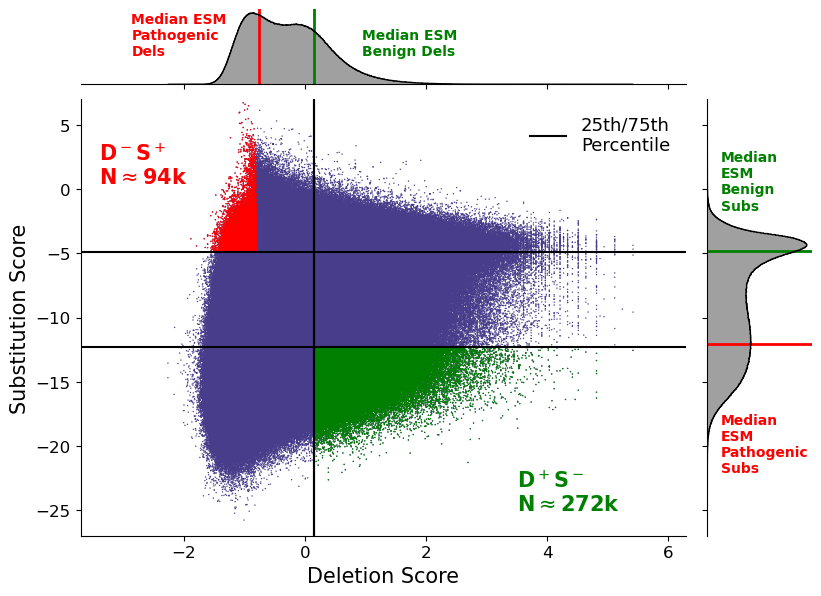

In [6]:
# remove this uniprot ID from visualization
plot_data = del_sub[(del_sub.prot != "Q156A1") & (del_sub.aPLLR != 0)]

num_bins=800
# plot full dataset
joint = sns.jointplot(data=plot_data, x='log_aPLLR', y="avg_LLR", color="darkslateblue", s=1, edgecolor='none',
                      marginal_kws=dict(bins=num_bins, edgecolor='none', color="grey", stat="density"))

# Add in percentile data
plt.axvline(-np.log10(del_tol), color="black")
plt.axvline(-np.log10(del_tol), color="black")
plt.axhline(sub_intol, color="black")
plt.axhline(sub_tol, color="black", label=f"{cutoff}th/{100-cutoff}th\nPercentile")

# plot differentially tolerant sites
sns.scatterplot(x=-np.log10(del_tol_sub_intol.query('prot!="Q156A1"').aPLLR), y=del_tol_sub_intol.query('prot!="Q156A1"').avg_LLR, color="green", s=1, edgecolor='none')
sns.scatterplot(x=-np.log10(del_intol_sub_tol.query('prot!="Q156A1"').aPLLR), y=del_intol_sub_tol.query('prot!="Q156A1"').avg_LLR, color="red", s=1, edgecolor='none')

####
# Marginal distributions with ClinVar median scores
ax_joint = joint.ax_joint
ax_marg_x = joint.ax_marg_x
ax_marg_y = joint.ax_marg_y

ax_marg_x.axvline(x=benign_dels_sumstats["50%"], color="green", lw=2)
ax_marg_x.axvline(x=pathogenic_dels_sumstats["50%"], color="red", lw=2)
ax_marg_x.hist(x=plot_data.log_aPLLR[plot_data.log_aPLLR != np.inf], histtype="step", color="black", bins=num_bins, density=True)
ax_marg_x.text(benign_dels_sumstats["50%"]+.8, 0.25, "Median ESM\nBenign Dels", color="green", weight="bold")
ax_marg_x.text(pathogenic_dels_sumstats["50%"]-2.1, 0.25, "Median ESM\nPathogenic\nDels", color="red", weight="bold")

ax_marg_y.axhline(y=benign_subs_sumstats["50%"], color="green", lw=2)
ax_marg_y.axhline(y=pathogenic_subs_sumstats["50%"], color="red", lw=2)
ax_marg_y.hist(x=plot_data.avg_LLR, histtype="step", color="black", orientation='horizontal', bins=num_bins, density=True)
ax_marg_y.text(0.02, benign_subs_sumstats["50%"]+3.2, "Median\nESM\nBenign\nSubs", color="green", weight="bold")
ax_marg_y.text(0.02, pathogenic_subs_sumstats["50%"]-10, "Median\nESM\nPathogenic\nSubs", color="red", weight="bold")
####

# Annotations, labels, etc
plt.xlabel("Deletion Score", size=15)
plt.ylabel("Substitution Score", size=15)

plt.ylim(-27, 7)
plt.xlim(-3.7, 6.3)

_=plt.text(3.5, -25, r'D$^+$S$^-$'+f"\nN" + r'$\approx$' + f"{int(np.round(del_tol_sub_intol.shape[0] / 1000, 1))}k", color="green", size=15, weight="bold")
_=plt.text(-3.4, .5, r'D$^-$S$^+$'+f"\nN" r'$\approx$' + f"{int(np.round(del_intol_sub_tol.shape[0] / 1000, 1))}k", color="red", size=15, weight="bold") 
plt.legend(loc="upper right", frameon=False, fontsize=13)

_=plt.xticks(size=12)
_=plt.yticks(size=12)

joint.fig.set_figwidth(4.7*1.8)
joint.fig.set_figheight(3.53*1.7)
plt.show()

## Figure B

### Process domain data from UniProt: Domain [FT] column from https://www.uniprot.org/uniprotkb?query=Human&facets=reviewed%3Atrue%2Cmodel_organism%3A9606

In [7]:
domains = pd.read_csv(paths.DOMAINS, sep="\t", usecols=["Entry", "Domain [FT]"]).rename(columns={"Domain [FT]": "domain"}).dropna(subset="domain")

# pivot data so each row contains one protein-domain pair
domains = domains[["Entry"]].join(domains.domain.str.split("DOMAIN ").apply(lambda x: x[1:])).explode("domain") 

# extract domain boundaries
domains["domain_start"] = domains.domain.str.split(";", expand=True)[0].str.split(".", expand=True)[0].astype(int)
domains["domain_end"] = domains.domain.str.split(";", expand=True)[0].str.split(".", expand=True)[2].apply(lambda x: ''.join(c for c in x if c.isnumeric())).astype(int)
domains = domains[["Entry", "domain_start", "domain_end"]]

In [8]:
esm_domains = del_sub.assign(pos=lambda x: x.site.str[1:].astype(int))\
                             .merge(domains, left_on="prot", right_on="Entry")\
                             .query('pos >= domain_start').query('pos <= domain_end')

### Extract differentially tolerant sites conditional on being in a domain

In [9]:
ed_del_tol = np.percentile(esm_domains.aPLLR, 25)
ed_del_intol = np.percentile(esm_domains.aPLLR, 75)
ed_sub_tol = np.percentile(esm_domains.avg_LLR, 75)
ed_sub_intol = np.percentile(esm_domains.avg_LLR, 25)

ed_del_tol_sub_intol = esm_domains[(esm_domains.aPLLR < ed_del_tol) & (esm_domains.avg_LLR < ed_sub_intol)]
ed_del_intol_sub_tol = esm_domains[(esm_domains.aPLLR > ed_del_intol) & (esm_domains.avg_LLR > ed_sub_tol)]

### Tsuboyama differential tolerance

In [10]:
tsuboyama = pd.read_csv("../data/tsuboyama_ddg.csv")

In [11]:
sub_tol_ddg, sub_intol_ddg = np.percentile(tsuboyama.ddG_ML_avg_subs, 75), np.percentile(tsuboyama.ddG_ML_avg_subs, 25)
del_tol_ddg, del_intol_ddg = np.percentile(tsuboyama.ddG_ML_dels, 75), np.percentile(tsuboyama.ddG_ML_dels, 25)

In [12]:
del_intol_sub_tol_ddg = tsuboyama[(tsuboyama.ddG_ML_dels < del_intol_ddg) & (tsuboyama.ddG_ML_avg_subs > sub_tol_ddg)]
del_tol_sub_intol_ddg = tsuboyama[(tsuboyama.ddG_ML_dels > del_tol_ddg) & (tsuboyama.ddG_ML_avg_subs < sub_intol_ddg)]

### Prepare data to plot

In [13]:
esm_data = [del_intol_sub_tol.shape[0] / del_sub.shape[0],
            del_tol_sub_intol.shape[0]/del_sub.shape[0]]
esm_data.append(1-sum(esm_data))

esm_domain_data = [ed_del_intol_sub_tol.shape[0]/esm_domains.shape[0], ed_del_tol_sub_intol.shape[0]/esm_domains.shape[0]]
esm_domain_data.append(1-sum(esm_domain_data))
                   
    
tsuboyama_data = [del_intol_sub_tol_ddg.shape[0] / tsuboyama.shape[0], del_tol_sub_intol_ddg.shape[0] / tsuboyama.shape[0]]
tsuboyama_data.append(1-sum(tsuboyama_data))

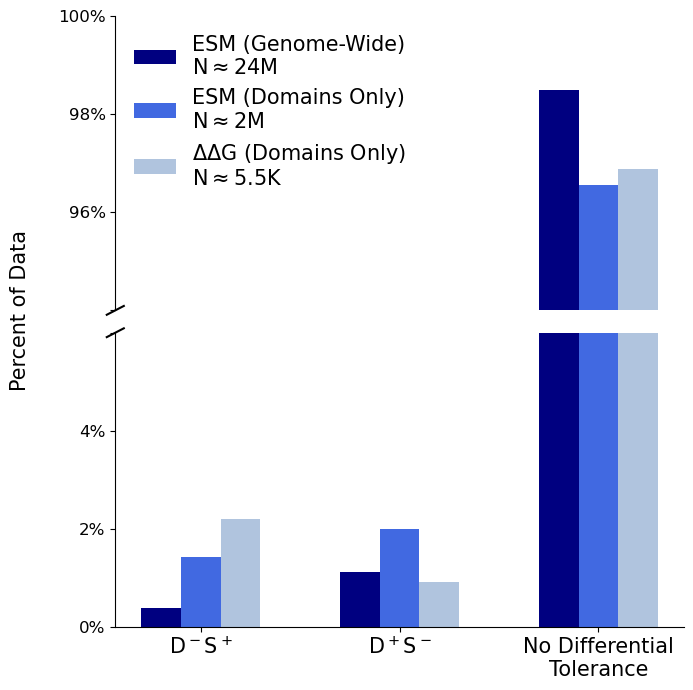

In [14]:
# Sample data
data = {
    'Group 1': esm_data,
    'Group 2': esm_domain_data,
    'Group 3': tsuboyama_data
}
index = [r'D$^-$S$^+$', r'D$^+$S$^-$', "No Differential\nTolerance"]
df = pd.DataFrame(data, index=index)


# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 7))

# Hide spines and adjust limits
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x', which='both', bottom=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(0, 0.03) # lower range of y axis
ax1.set_ylim(0.95, 1) # upper range of y axis

yrange2 = np.arange(0, 0.07, step=0.02)
ax2.set_yticks(yrange2, [f"{int(x*100)}%" for x in yrange2[0:-1]] + [""], size=12)
yrange1 = np.arange(0.94, 1, step=0.02)
ax1.set_yticks(yrange1, [""] + [f"{int(x*100)}%" for x in yrange1[1:]], size=12)

# Plot grouped bar plots
bar_width = 0.2
index = np.arange(len(df))

x = np.arange(3)  # the label locations
x1 = x - bar_width
x2 = x
x3 = x + bar_width

ax1.bar(x1, df['Group 1'], bar_width, color="navy",
        label='ESM (Genome-Wide)\n' + r'N$\approx$' + f"{str(int(del_sub.shape[0] / 1000000)) + "M"}")
ax1.bar(x2, df['Group 2'], bar_width, color="royalblue",
        label="ESM (Domains Only)\n" + r'N$\approx$' + f"{str(int(esm_domains.shape[0] / 1000000)) + "M"}")
ax1.bar(x3, df['Group 3'], bar_width, color="lightsteelblue",
        label=r'$\Delta\Delta$G (Domains Only)' + "\n" + r'N$\approx$' + f"{str(round(tsuboyama.shape[0] / 1000, 1))}" + "K")

ax2.bar(x1, df['Group 1'], bar_width, color=["navy", "navy", "navy"])
ax2.bar(x2, df['Group 2'], bar_width, color=["royalblue", "royalblue", "royalblue"])
ax2.bar(x3, df['Group 3'], bar_width, color=["lightsteelblue", "lightsteelblue", "lightsteelblue"])

["navy", "royalblue", "lightsteelblue"]

# Add line breaks
d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

# Customize plot
ax2.set_xticks(index)
ax2.set_xticklabels(df.index, size=15)

ax1.set_ylabel("Percent of Data", size=15)
ax1.yaxis.set_label_coords(-0.15, 0)

ax1.legend(loc="upper left", frameon=False, fontsize=15)

plt.tight_layout()
plt.show()